# Training_Logistic_Regression_model_for_Sub-Challenge_2

**Background:**

**Purpose:** To train a logistic regression model for sub-challenge 2 using the MLFlow setup from Sub-Challenge 1

**Methods:**
>1. Introduction
>2. Inits

**Conclusions:**
* Again, using SMOTE over-sampling improves the class 0 performance
* Final model:
   * lower_quantile_removed_CoV=0
   * log10_C=-1.5
   * log10_max_iter=3.0
   * use_smote=True

# Inits

## Imports

In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context(context='notebook', font_scale=1.5)

import logging
logging.basicConfig()
logger = logging.getLogger()
logger.setLevel(logging.INFO)

from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.linear_model import LogisticRegression

import mlflow

# Load my own custom module
import data_loading
import model_funcs
import constants

import imblearn
import joblib

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import sklearn.metrics as skl_metrics

from plotnine import *

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/patsy/constraint.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


## Definitions

In [3]:
experiment_base_path = f'{constants.base_dir}/mlruns/'

test_param_dict = {'C': 1e-1,
                 'max_iter': 100,
                 'solver': 'saga',
                 'class_weight': None,
                 'lower_quantile_removed_CoV': 0,
                  'use_smote': True}

## Funcs

### Running mlflow experiment

In [14]:
def run_mlflow_exp_v8(X_cv_orig, X_test_orig, y_cv_orig, y_test_orig, curr_param_index, curr_params_dict):
    
    X_cv = X_cv_orig.copy()
    X_test = X_test_orig.copy()
    y_cv = y_cv_orig.copy()
    y_test = y_test_orig.copy()
    
    # Set the experiment name
    mlflow.set_tracking_uri(f'file://{experiment_base_path}')

    # Start a mlflow run
    with mlflow.start_run():
        mlflow.set_tag('description', 
        """
        Sub-Challenge 2: First experiment
        """)

        # Define the model
        log_regr_clf = LogisticRegression(penalty='l1',
                                          C=curr_params_dict['C'],
                                          class_weight=curr_params_dict['class_weight'],
                                          random_state=110,
                                          solver=curr_params_dict['solver'],
                                          max_iter=curr_params_dict['max_iter'],
                                          verbose=0,
                                          n_jobs=None,
                                          l1_ratio=None)

        # Remove the lowest quartile of genes based on CoV
        # Calculate the CoV
        gene_expr_cov_list = 100 * (X_cv.std(ddof=1, axis=0) / X_cv.mean(axis=0))

        # Calculate the 0.25 quantile
        min_cov_threshold = np.quantile(gene_expr_cov_list, q=[curr_params_dict['lower_quantile_removed_CoV']])[0]

        # Get a list of genes to removed
        low_cov_gene_list = gene_expr_cov_list.loc[(gene_expr_cov_list < min_cov_threshold)].index.tolist()

        # Remove the lowest 0.25 quantile of genes based on CoV
        X_cv.drop(low_cov_gene_list, axis=1, inplace=True)
        X_test.drop(low_cov_gene_list, axis=1, inplace=True)

        # Run custom CV so I can train on over-sampled data but test on original data
        kfold_obj = KFold(n_splits=5, shuffle=True)

        cv_train_accuracy_list = []
        cv_test_accuracy_list = []
        cv_test_accuracy_of_0_cases_list = []

        for curr_train_iloc_list, curr_test_iloc_list in kfold_obj.split(X=X_cv, y=y_cv):

            # Create current fold train data
            curr_fold_X_train = X_cv.iloc[curr_train_iloc_list, ]
            curr_fold_y_train = y_cv.iloc[curr_train_iloc_list, ]

            # Create current fold train data
            curr_fold_X_test = X_cv.iloc[curr_test_iloc_list, ]
            curr_fold_y_test = y_cv.iloc[curr_test_iloc_list, ]

            # Run SMOTE on the X,y data
            if curr_params_dict['use_smote']:
                smote_obj = imblearn.over_sampling.SMOTE(sampling_strategy='auto', 
                                                         random_state=110, 
                                                         k_neighbors=5, 
                                                         n_jobs=None)

                curr_fold_X_train, curr_fold_y_train = smote_obj.fit_sample(curr_fold_X_train, curr_fold_y_train)

            # Train the model for this k-fold
            log_regr_clf.fit(curr_fold_X_train, curr_fold_y_train)

            # Calculate accuracy on non-oversampled data
            curr_fold_y_train_pred = pd.Series(log_regr_clf.predict(curr_fold_X_train), index=curr_fold_y_train.index)
            curr_fold_y_test_pred = pd.Series(log_regr_clf.predict(curr_fold_X_test), index=curr_fold_y_test.index)

            # Calculate result metrics like accuracy
            cv_train_accuracy_list.append((curr_fold_y_train_pred == curr_fold_y_train).mean())
            cv_test_accuracy_list.append((curr_fold_y_test_pred == curr_fold_y_test).mean())

            # Calculate the test accuracy of target=0 cases
            cv_test_accuracy_of_0_cases_list.append(np.mean(curr_fold_y_test_pred[(curr_fold_y_test == 0)] == 0))


        # Run SMOTE on the full X_cv,y_cv data
        if curr_params_dict['use_smote']:
            smote_obj = imblearn.over_sampling.SMOTE(sampling_strategy='auto', 
                                                     random_state=110, 
                                                     k_neighbors=5, 
                                                     n_jobs=None)
            X_cv, y_cv = smote_obj.fit_sample(X_cv, y_cv)

        # Train the model
        log_regr_clf.fit(X_cv, y_cv)
        
        # Calculate test accuracy
        y_test_pred = pd.Series(log_regr_clf.predict(X_test), index=y_test.index)
        test_accuracy = (y_test_pred == y_test).mean()
        
        # Calculate the false positive rate and true positive rate
        train_auc = skl_metrics.roc_auc_score(y_true=y_cv, 
                                             y_score=log_regr_clf.predict_proba(X_cv)[:, 1])
        test_auc = skl_metrics.roc_auc_score(y_true=y_test, 
                                             y_score=log_regr_clf.predict_proba(X_test)[:, 1])

        # Log parameters
        mlflow.log_param("log10_C", np.log10(curr_params_dict['C']))
        mlflow.log_param("log10_max_iter", np.log10(curr_params_dict['max_iter']))
        mlflow.log_param("solver", curr_params_dict['solver'])
        mlflow.log_param("class_weight", curr_params_dict['class_weight'])
        mlflow.log_param("lower_quantile_removed_CoV", curr_params_dict['lower_quantile_removed_CoV'])
        mlflow.log_param("use_smote", curr_params_dict['use_smote'])

        # Log the CV metrics
        mlflow.log_metric("cv_training_accuracy", np.mean(cv_train_accuracy_list))
        mlflow.log_metric("cv_test_accuracy", np.mean(cv_test_accuracy_list))
        mlflow.log_metric("cv_test_0_class_accuracy", np.mean(cv_test_accuracy_of_0_cases_list))
        
        # Log test metrics
        mlflow.log_metric("test_accuracy", test_accuracy)
        mlflow.log_metric("train_auc", train_auc)
        mlflow.log_metric("test_auc", test_auc)

        # Log count of non-zero features
        mlflow.log_metric("count_non_zero_features", np.sum(log_regr_clf.coef_[0] != 0))

# Loading subchallenge 2 data

In [8]:
def load_sc2_data():
    sc2_Phase1_CN_FeatureMatrix = pd.read_csv(f'{constants.base_dir}/data/raw/sc2_Phase1_CN_FeatureMatrix.tsv', sep    ='\t')\
        .set_index('PATIENTID')
    sc2_Phase1_CN_Outcome = pd.read_csv(f'{constants.base_dir}/data/raw/sc2_Phase1_CN_Outcome.tsv', sep='\t')\
        .set_index('PATIENTID')
    sc2_Phase1_CN_Phenotype = pd.read_csv(f'{constants.base_dir}/data/raw/sc2_Phase1_CN_Phenotype.tsv', sep='\t')\
        .set_index('PATIENTID')
    
    return sc2_Phase1_CN_FeatureMatrix, sc2_Phase1_CN_Outcome['SURVIVAL_STATUS'], sc2_Phase1_CN_Phenotype

# Creating a model and predicting outcome from sub-challenge 2 data

In [20]:
curr_param_index=0
curr_params_dict=test_param_dict

# Set the experiment name
mlflow.set_tracking_uri(f'file://{experiment_base_path}')
mlflow.set_experiment('SC2-V1-l1-Logistic_Regression_Exp')

# Start a mlflow run
with mlflow.start_run():
    mlflow.set_tag('description', 
    """
    Sub-Challenge 2: First experiment
    """)

    # Define the model
    log_regr_clf = LogisticRegression(penalty='l1',
                                      C=curr_params_dict['C'],
                                      class_weight=curr_params_dict['class_weight'],
                                      random_state=110,
                                      solver=curr_params_dict['solver'],
                                      max_iter=curr_params_dict['max_iter'],
                                      verbose=0,
                                      n_jobs=None,
                                      l1_ratio=None)

    # Load the gene expression (GE) raw data from file
    X, y, phenotype_df = data_loading.load_sc2_data()
    
    # Remove the lowest quartile of genes based on CoV
    # Calculate the CoV
    gene_expr_cov_list = 100 * (X.std(ddof=1, axis=0) / X.mean(axis=0))

    # Calculate the 0.25 quantile
    min_cov_threshold = np.quantile(gene_expr_cov_list, q=[curr_params_dict['lower_quantile_removed_CoV']])[0]

    # Get a list of genes to removed
    low_cov_gene_list = gene_expr_cov_list.loc[(gene_expr_cov_list < min_cov_threshold)].index.tolist()

    # Remove the lowest 0.25 quantile of genes based on CoV
    X.drop(low_cov_gene_list, axis=1, inplace=True)

    # Split into CV/test set using target class to stratify
    X_cv, X_test, y_cv, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

    # Run custom CV so I can train on over-sampled data but test on original data
    kfold_obj = KFold(n_splits=5, shuffle=True)

    cv_train_accuracy_list = []
    cv_test_accuracy_list = []
    cv_test_accuracy_of_0_cases_list = []

    for curr_train_iloc_list, curr_test_iloc_list in kfold_obj.split(X=X_cv, y=y_cv):

        # Create current fold train data
        curr_fold_X_train = X_cv.iloc[curr_train_iloc_list, ]
        curr_fold_y_train = y_cv.iloc[curr_train_iloc_list, ]

        # Create current fold train data
        curr_fold_X_test = X_cv.iloc[curr_test_iloc_list, ]
        curr_fold_y_test = y_cv.iloc[curr_test_iloc_list, ]

        # Run SMOTE on the X,y data
        if curr_params_dict['use_smote']:
            smote_obj = imblearn.over_sampling.SMOTE(sampling_strategy='auto', 
                                                     random_state=110, 
                                                     k_neighbors=5, 
                                                     n_jobs=None)

            curr_fold_X_train, curr_fold_y_train = smote_obj.fit_sample(curr_fold_X_train, curr_fold_y_train)

        # Train the model for this k-fold
        log_regr_clf.fit(curr_fold_X_train, curr_fold_y_train)

        # Calculate accuracy on non-oversampled data
        curr_fold_y_train_pred = pd.Series(log_regr_clf.predict(curr_fold_X_train), index=curr_fold_y_train.index)
        curr_fold_y_test_pred = pd.Series(log_regr_clf.predict(curr_fold_X_test), index=curr_fold_y_test.index)

        # Calculate result metrics like accuracy
        cv_train_accuracy_list.append((curr_fold_y_train_pred == curr_fold_y_train).mean())
        cv_test_accuracy_list.append((curr_fold_y_test_pred == curr_fold_y_test).mean())

        # Calculate the test accuracy of target=0 cases
        cv_test_accuracy_of_0_cases_list = np.mean(curr_fold_y_test_pred[(curr_fold_y_test == 0)] == 0)


    # Run SMOTE on the full X_cv,y_cv data
    if curr_params_dict['use_smote']:
        smote_obj = imblearn.over_sampling.SMOTE(sampling_strategy='auto', 
                                                 random_state=110, 
                                                 k_neighbors=5, 
                                                 n_jobs=None)
        X_cv, y_cv = smote_obj.fit_sample(X_cv, y_cv)

    # Train the model
    log_regr_clf.fit(X_cv, y_cv)

    # Log parameters
    mlflow.log_param("log10_C", np.log10(curr_params_dict['C']))
    mlflow.log_param("log10_max_iter", np.log10(curr_params_dict['max_iter']))
    mlflow.log_param("solver", curr_params_dict['solver'])
    mlflow.log_param("class_weight", curr_params_dict['class_weight'])
    mlflow.log_param("lower_quantile_removed_CoV", curr_params_dict['lower_quantile_removed_CoV'])
    mlflow.log_param("use_smote", curr_params_dict['use_smote'])

    # Log accuracy metrics
    mlflow.log_metric("cv_training_accuracy", np.mean(cv_train_accuracy_list))
    mlflow.log_metric("cv_test_accuracy", np.mean(cv_test_accuracy_list))
    mlflow.log_metric("cv_test_0_class_accuracy", np.mean(cv_test_accuracy_of_0_cases_list))

    # Log count of non-zero features
    mlflow.log_metric("count_non_zero_features", np.sum(log_regr_clf.coef_[0] != 0))

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

# Exp 1 - Running MLFlow

In [18]:
%%time

# Set the experiment name
mlflow.set_tracking_uri(f'file://{experiment_base_path}')
mlflow.set_experiment('SC2-V8-Exp_1-L1-Logistic_Regression_Exp')
    
# Define the parameter grid
param_dict = {'C': np.logspace(-2, 0, 5).tolist() + np.logspace(1, 5, 3).tolist(),
             'max_iter': [1000],
             'solver': ['saga'],
             'class_weight': [None],
             'lower_quantile_removed_CoV': [0, 0.25, 0.5, 0.9],
             'use_smote': [True]}

# Load the gene expression (GE) raw data from file
X, y, phenotype_df = data_loading.load_sc2_data()
        
# Split into CV/test set using target class to stratify
X_cv, X_test, y_cv, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=110)

# Run mlflow runs in parallel
results = joblib.Parallel(n_jobs=-1, backend='multiprocessing')\
    (joblib.delayed(run_mlflow_exp_v8)(X_cv, X_test, y_cv, y_test, curr_param_index, curr_params_dict)\
         for curr_param_index, curr_params_dict in enumerate(ParameterGrid(param_dict)))

INFO: 'SC2-V8-Exp_1-L1-Logistic_Regression_Exp' does not exist. Creating a new experiment


/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site

CPU times: user 210 ms, sys: 91.3 ms, total: 301 ms
Wall time: 20.1 s


## Getting the results as a dataframe

In [16]:
# Get the experiment id from the experiment name
curr_experiment_id=mlflow.get_experiment_by_name('SC2-V8-l1-Logistic_Regression_Exp').experiment_id

experiment_results_v1_df = mlflow.search_runs(experiment_ids=curr_experiment_id)\
    .rename(columns={'metrics.cv_test_accuracy_of_0_cases_list': 'metrics.cv_test_0_class_accuracy'})

# Melt the dataframe to get accuracy as a single column
experiment_results_v1_df_melt = experiment_results_v1_df\
    .melt(id_vars=['run_id','metrics.count_non_zero_features','params.lower_quantile_removed_CoV','params.log10_C','params.log10_max_iter','params.use_smote'],
          value_vars=['metrics.cv_training_accuracy','metrics.cv_test_accuracy','metrics.cv_test_0_class_accuracy'],
          var_name='train_or_cv',
          value_name='accuracy')

AttributeError: 'NoneType' object has no attribute 'experiment_id'

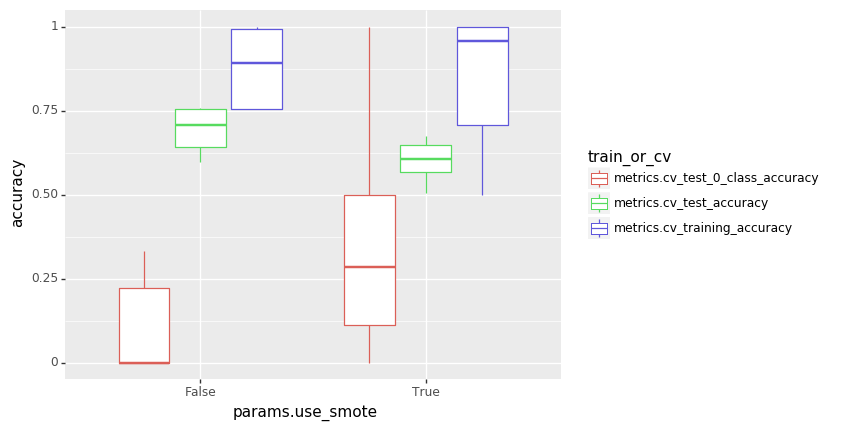

<ggplot: (8726192002117)>

In [27]:
plot_df = experiment_results_v1_df_melt.copy()

(ggplot(data=plot_df) 
 + geom_boxplot(aes(x='params.use_smote', 
                  y='accuracy', 
                  color='train_or_cv'))
)

**Again, using SMOTE over-sampling improves the class 0 performance**

In [32]:
experiment_results_v1_df_melt_v1 = experiment_results_v1_df_melt.loc[experiment_results_v1_df_melt['params.use_smote'] == 'True']

### Looking at maximum iteration influence

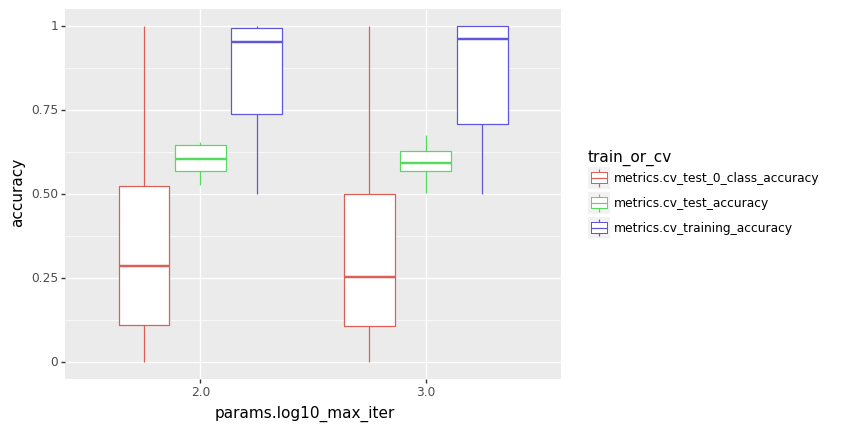

<ggplot: (8726191797101)>

In [35]:
plot_df = experiment_results_v1_df_melt_v1.copy()

(ggplot(data=plot_df) 
 + geom_boxplot(aes(x='params.log10_max_iter', 
                  y='accuracy', 
                  color='train_or_cv'))
)

There seems to be no major difference between 100 and 1,000 iterations overall

In [36]:
experiment_results_v1_df_melt_v2 = experiment_results_v1_df_melt_v1.loc[experiment_results_v1_df_melt_v1['params.log10_max_iter'] == '3.0']

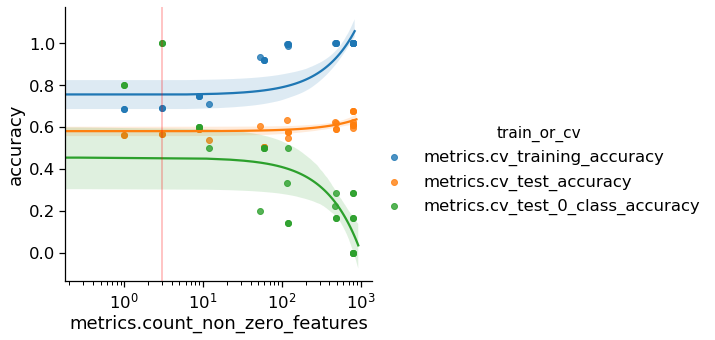

In [48]:
sns.lmplot(x='metrics.count_non_zero_features',
           y='accuracy',
           data=experiment_results_v1_df_melt_v2,
           hue='train_or_cv', 
           fit_reg=True, size=5, aspect=1.25)

ax = plt.gca()
ax.set_xscale('log')
ax.axvline(3, c='r', alpha=0.3)

* As the # of features in the model increases, the class 0 performance worsens as the training accuracty increases
* The test accuracy stays fairly stable around 60%
* 3 features are nearly as predictive >100 features for the test set

In [51]:
experiment_results_v1_df_melt_v2\
    .loc[(experiment_results_v1_df_melt_v2['metrics.count_non_zero_features'] < 5)\
        & (experiment_results_v1_df_melt_v2['metrics.count_non_zero_features'] > 0)]

,run_id,metrics.count_non_zero_features,params.lower_quantile_removed_CoV,params.log10_C,params.log10_max_iter,params.use_smote,train_or_cv,accuracy
97,8ac88453b19b440b9ad6ea5426c3b238,1.0,0.9,-1.5,3.0,True,metrics.cv_training_accuracy,0.687000
101,31451ba324414e769da6e27ebe84e7b9,1.0,0.5,-1.5,3.0,True,metrics.cv_training_accuracy,0.687000
105,88494373c30342b5a9df4bcb4c674893,3.0,0.25,-1.5,3.0,True,metrics.cv_training_accuracy,0.692829
108,a6662a30898249268eb0cde0bcfafc55,3.0,0,-1.5,3.0,True,metrics.cv_training_accuracy,0.692829
225,8ac88453b19b440b9ad6ea5426c3b238,1.0,0.9,-1.5,3.0,True,metrics.cv_test_accuracy,0.561376
229,31451ba324414e769da6e27ebe84e7b9,1.0,0.5,-1.5,3.0,True,metrics.cv_test_accuracy,0.561376
233,88494373c30342b5a9df4bcb4c674893,3.0,0.25,-1.5,3.0,True,metrics.cv_test_accuracy,0.567725
236,a6662a30898249268eb0cde0bcfafc55,3.0,0,-1.5,3.0,True,metrics.cv_test_accuracy,0.567725
353,8ac88453b19b440b9ad6ea5426c3b238,1.0,0.9,-1.5,3.0,True,metrics.cv_test_0_class_accuracy,0.800000
357,31451ba324414e769da6e27ebe84e7b9,1.0,0.5,-1.5,3.0,True,metrics.cv_test_0_class_accuracy,0.800000


Final model:
* lower_quantile_removed_CoV=0
* log10_C=-1.5
* log10_max_iter=3.0
* use_smote=True

In [42]:
_, y, _ = data_loading.load_sc2_data()

In [46]:
y.value_counts() / y.shape[0]

1    0.752874
0    0.247126
Name: SURVIVAL_STATUS, dtype: float64

# Exp 1 - Investigating AUC of train vs. test

In [19]:
# Get the experiment id from the experiment name
curr_experiment_id=mlflow.get_experiment_by_name('SC2-V8-Exp_1-L1-Logistic_Regression_Exp').experiment_id

experiment_results_v1_df = mlflow.search_runs(experiment_ids=curr_experiment_id)\
    .rename(columns={'metrics.cv_test_accuracy_of_0_cases_list': 'metrics.cv_test_0_class_accuracy'})

# Melt the dataframe to get accuracy as a single column
experiment_results_v1_df_melt = experiment_results_v1_df\
    .melt(id_vars=['run_id','metrics.count_non_zero_features','params.lower_quantile_removed_CoV','params.log10_C','params.log10_max_iter','params.use_smote'],
          value_vars=['metrics.cv_training_accuracy','metrics.cv_test_accuracy','metrics.cv_test_0_class_accuracy'],
          var_name='train_or_cv',
          value_name='accuracy')

In [22]:
experiment_results_v1_df.loc[:, ['params.log10_C','metrics.count_non_zero_features','metrics.train_auc','metrics.test_auc']]

,params.log10_C,metrics.count_non_zero_features,metrics.train_auc,metrics.test_auc
0,5.0,790.0,1.000000,0.606838
1,5.0,790.0,1.000000,0.606838
2,5.0,790.0,1.000000,0.606838
3,5.0,790.0,1.000000,0.606838
4,3.0,790.0,1.000000,0.606838
5,3.0,790.0,1.000000,0.606838
6,3.0,790.0,1.000000,0.606838
7,3.0,790.0,1.000000,0.606838
8,1.0,499.0,1.000000,0.619658
9,1.0,499.0,1.000000,0.619658


# Exp 2 - Generating many train/cv/test results

## Running MLFlow experiment

In [ ]:
%%time

# Set the experiment name
mlflow.set_tracking_uri(f'file://{experiment_base_path}')
mlflow.set_experiment('SC2-V10-Exp_2-L1-Logistic_Regression_Exp')
    
# Define the parameter grid
param_dict = {'C': np.logspace(-2, 0, 9).tolist() + np.logspace(1, 5, 3).tolist(),
             'max_iter': [100],
             'solver': ['saga'],
             'class_weight': [None],
             'lower_quantile_removed_CoV': [0, 0.25, 0.5, 0.9],
             'use_smote': [True]}

# Load the gene expression (GE) raw data from file
X, y, phenotype_df = data_loading.load_sc2_data()

# For 10 different cv/test splits
for i in range(15):
    # Split into CV/test set using target class to stratify
    X_cv, X_test, y_cv, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

    #model_funcs.run_mlflow_exp_V10(X_cv, X_test, y_cv, y_test, test_param_dict, experiment_base_path)

    # Run mlflow runs in parallel
    results = joblib.Parallel(n_jobs=-1, backend='multiprocessing')\
        (joblib.delayed(model_funcs.run_mlflow_exp_V10)(X_cv, X_test, y_cv, y_test, curr_params_dict, experiment_base_path)\
             for curr_param_index, curr_params_dict in enumerate(ParameterGrid(param_dict)))

## Creating a dataframe with the experiment results

In [5]:
# Get the experiment id from the experiment name
curr_experiment_id=mlflow.get_experiment_by_name('SC2-V10-Exp_2-L1-Logistic_Regression_Exp').experiment_id

experiment_results_sc2_v10_exp2_df = mlflow.search_runs(experiment_ids=curr_experiment_id)\
    .rename(columns={'metrics.cv_test_accuracy_of_0_cases_list': 'metrics.cv_test_0_class_accuracy'})

# Melt the dataframe to get accuracy as a single column
experiment_results_sc2_v10_exp2_df_melt = experiment_results_sc2_v10_exp2_df\
    .melt(id_vars=['run_id','metrics.count_non_zero_features','params.lower_quantile_removed_CoV','params.log10_C','params.log10_max_iter','params.use_smote'],
          value_vars=['metrics.cv_training_accuracy','metrics.cv_test_accuracy','metrics.cv_test_0_class_accuracy'],
          var_name='train_or_cv',
          value_name='accuracy')

experiment_results_sc2_v10_exp2_df_melt['metrics.log10_count_non_zero_features'] = np.log10(experiment_results_sc2_v10_exp2_df_melt['metrics.count_non_zero_features'] + 1)

## Plotting feature count vs. CV accuracies

/home/alex/miniconda3/envs/precfda_bc/lib/python3.7/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


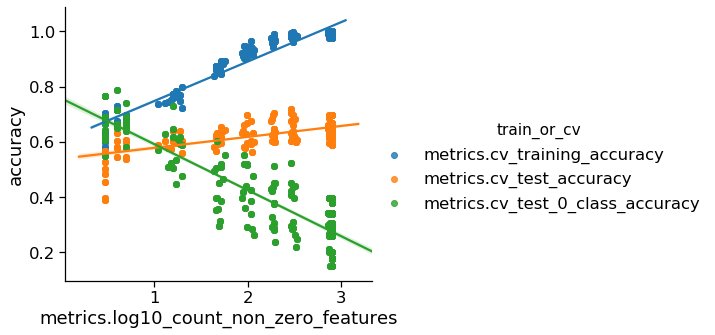

In [6]:
plot_df = experiment_results_sc2_v10_exp2_df_melt\
    .loc[experiment_results_sc2_v10_exp2_df_melt['metrics.count_non_zero_features'] > 1]


sns.lmplot(x='metrics.log10_count_non_zero_features',
           y='accuracy',
           data=plot_df,
           hue='train_or_cv', 
           fit_reg=True, size=5, aspect=1.25)

ax = plt.gca()
#ax.set_xscale('log')
#ax.axvline(3, c='r', alpha=0.3)

This shows that using using ~10 features is a good compromise between class 0 test accuracy and overall test accuracy. If we use too many more features, the overall test accuracy does improve a bit but the class 0 accuracy plummets.

## Plotting boxplot of accuracy vs. log10(C)

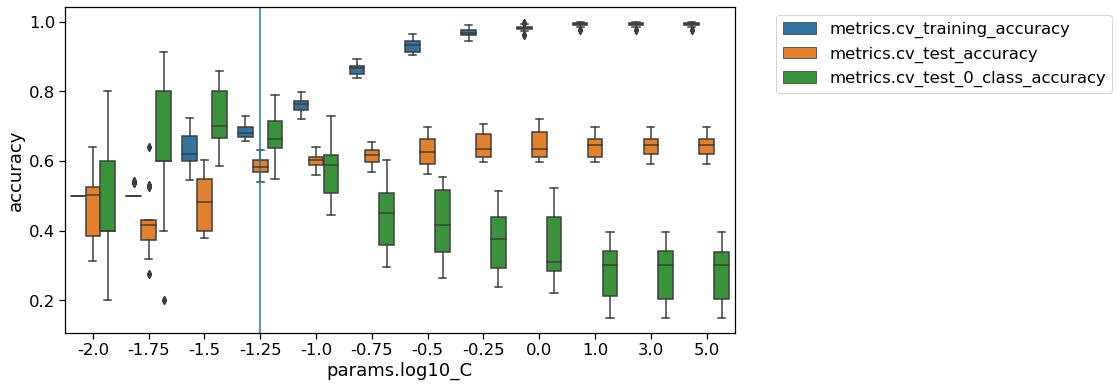

In [7]:
plot_df = experiment_results_sc2_v10_exp2_df_melt\
#    .loc[experiment_results_sc2_v10_exp2_df_melt['metrics.count_non_zero_features'] > 1]

plt.figure(figsize=(12,6))
ax=plt.gca()

sns.boxplot(x='params.log10_C',
           y='accuracy',
           data=plot_df,
           hue='train_or_cv', 
           order=['-2.0', '-1.75', '-1.5', '-1.25', '-1.0', '-0.75', '-0.5', '-0.25', 
                  '0.0', '1.0', '3.0', '5.0'],
           ax=ax)

ax.legend(bbox_to_anchor=(1.05,1))
#ax.axhline(0.5, c='g')
ax.axvline(3)

log10_C=-1.25 is the clear winner here; It balances the overall and class 0 test accuracy

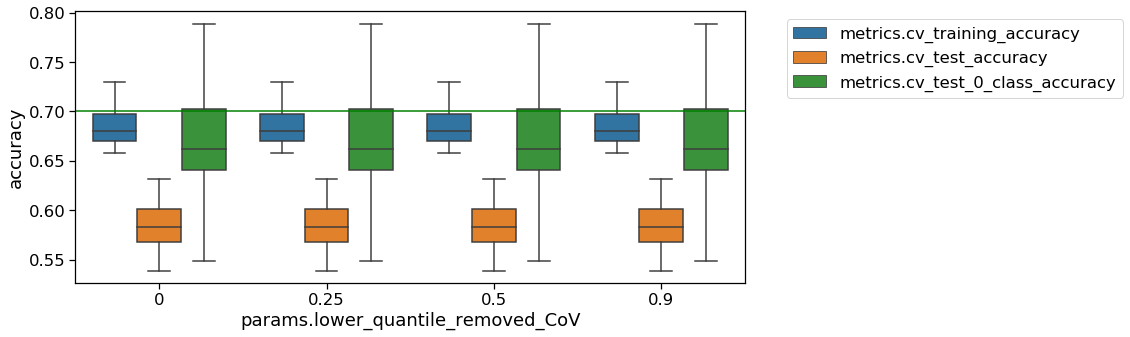

In [8]:
plot_df = experiment_results_sc2_v10_exp2_df_melt\
    .loc[experiment_results_sc2_v10_exp2_df_melt['params.log10_C'] == '-1.25']

plt.figure(figsize=(12,5))
ax=plt.gca()

sns.boxplot(x='params.lower_quantile_removed_CoV',
           y='accuracy',
           data=plot_df,
           hue='train_or_cv', 
           ax=ax)

ax.legend(bbox_to_anchor=(1.05,1))
ax.axhline(0.7, c='g')
#ax.axvline(1)

There is no difference in performance based on the quantiles of low CoV genes removed

Final model:
* log10_C=-1.25
* lower_quantile_removed_CoV=0.25

In [109]:
experiment_results_sc2_v10_exp2_df\
    .loc[(experiment_results_sc2_v10_exp2_df['params.log10_C'] == '-1.25')
        & (experiment_results_sc2_v10_exp2_df['params.lower_quantile_removed_CoV'] == '0')]\
    .filter(regex='metrics.*')\
    .describe()

,metrics.train_auc,metrics.cv_training_accuracy,metrics.cv_test_0_class_accuracy,metrics.cv_test_accuracy,metrics.test_accuracy,metrics.count_non_zero_features,metrics.cv_test_auc,metrics.test_auc
count,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000
mean,0.713705,0.690720,0.648974,0.578977,0.539048,3.133333,0.613903,0.569516
std,0.035381,0.017205,0.076880,0.032018,0.082855,1.407463,0.036589,0.095165
min,0.657778,0.665561,0.537143,0.517460,0.371429,1.000000,0.554062,0.320513
25%,0.687460,0.680889,0.587716,0.561376,0.500000,2.500000,0.589146,0.553419
50%,0.709841,0.686643,0.653333,0.582804,0.542857,3.000000,0.617647,0.589744
75%,0.738458,0.700538,0.717857,0.593651,0.571429,3.500000,0.632843,0.621795
max,0.776871,0.730981,0.785714,0.662698,0.742857,6.000000,0.678711,0.673077


## Get the full feature list

In [110]:
import glob

# Get the full run_id list for this experiment
run_id_list = experiment_results_sc2_v10_exp2_df\
    .loc[(experiment_results_sc2_v10_exp2_df['params.log10_C'] == '-1.25')
        & (experiment_results_sc2_v10_exp2_df['params.lower_quantile_removed_CoV'] == '0')]\
    ['run_id']

full_feature_list = []

for curr_run_id in run_id_list:
    # Get the current run's artifact uri
    curr_run = mlflow.get_run(run_id=curr_run_id)
    curr_artifact_uri = curr_run.to_dictionary()['info']['artifact_uri']

    # Get the feature list filepath
    feature_list_filepath = glob.glob(f'{curr_artifact_uri[7:]}/*')[0]
    
    # Open the feature list file
    with open(feature_list_filepath, 'r') as f:
        # Get the first feature
        curr_feature = f.readline()

        # While the current feature name is not empty
        while curr_feature != '':
            # Add the feature to the full feature list
            full_feature_list.append(f.readline().strip())
            
            # Get the next feature
            curr_feature = f.readline()

# Remove any empty feature from the final list
full_feature_list = [curr_feature for curr_feature in full_feature_list if len(curr_feature) > 0]

In [117]:
pd.Series(full_feature_list).value_counts()

7q31.1     5
9p21.3     4
10p15.3    2
7p15.3     2
8q23.3     2
7p12.1     1
7p11.2     1
8q23.1     1
dtype: int64

# Output the feature list

In [118]:
with open('./../../data/intermediate/CN_feature_list.txt', 'w') as f:
    for curr_feature in np.sort(np.unique(full_feature_list)):
        if len(curr_feature) > 0:
            f.write(f'{curr_feature}\n')